# Generating Transmission Spectra




### Stellar and Planet Properties

In [ ]:
from POSEIDON.core import create_star
from POSEIDON.constants import R_Sun

#***** Define stellar properties *****#

R_s = 0.87*R_Sun      # Stellar radius (m)
T_s = 5079.0          # Stellar effective temperature (K)
Met_s = -0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

In [2]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J

#***** Define planet properties *****#

planet_name = 'HAT-P-26b'  # Planet name used for plots, output files etc.

R_p = 0.63*R_J      # Planetary radius (m)
M_p = 0.07*M_J      # Mass of planet (kg)
g_p = 4.3712        # Gravitational field of planet (m/s^2)
T_eq = 1043.8       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, gravity = g_p, T_eq = T_eq)

### Defining a Model



In [3]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Simple_model'  # Model name used for plots, output files etc.

bulk_species = ['H2']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']   # The trace gases are H2O and CH4

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

### Specify a Planetary Atmosphere



To generate our atmosphere, we need to provide the following information:

1. A pressure grid for the atmosphere.
2. Parameters defining the mixing ratios.
3. Parameters defining any clouds / aerosols (if included).
4. Parameters defining the atmospheric geometry (2D and 3D models only).



In [6]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1500])              # T (K)
log_X_params = np.array([-3.0])     # log(H2O)

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

We can now plot our atmosphere, temperature profile, and mixing ratio profiles.

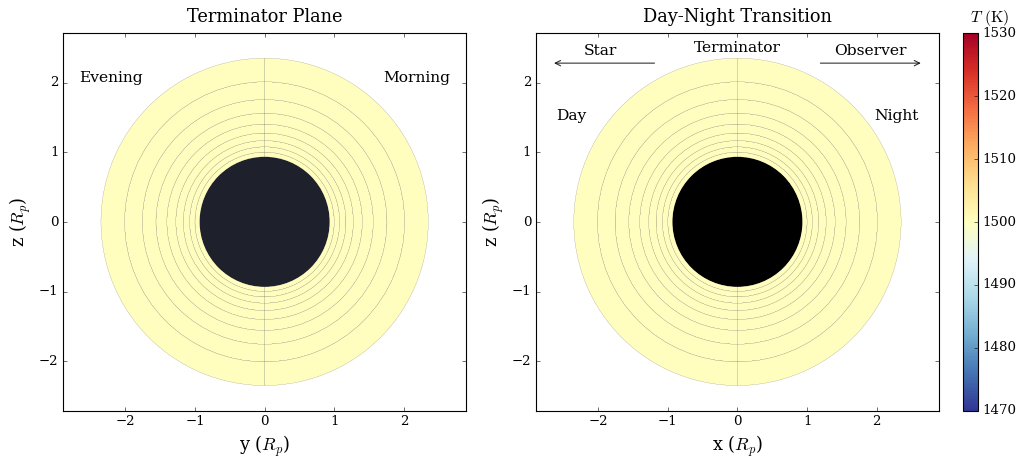

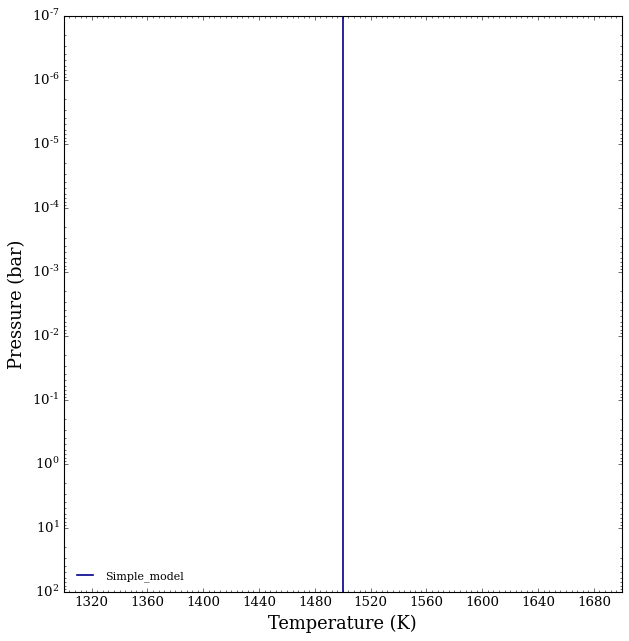

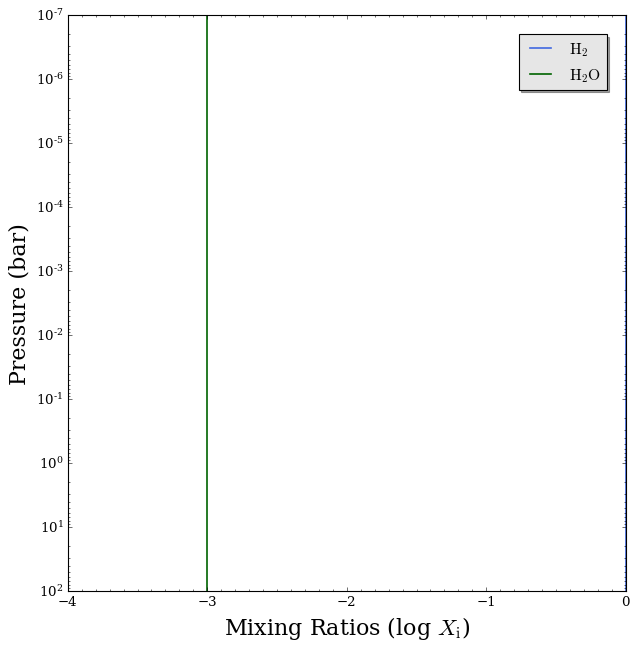

In [7]:
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)
fig_PT = plot_PT(planet, model, atmosphere)  
fig_chem = plot_chem(planet, model, atmosphere)

### Load Opacities

Before we can make a spectrum of our planet, we need to read in the cross sections / opacity data required by our model.

POSEIDON's opacity database includes high spectral resolution line-by-line cross sections ($\Delta \tilde{\nu} = 0.01$ cm<sup>-1</sup>, equivalent to $R = \lambda / \Delta \lambda = 10^6$ at 1 micron) for over 50 chemical species, precomputed on a grid of 162 pressure-temperature points. In addition to these cross sections, absorption from pair processes — collision-induced absorption (CIA) and free-free absorption — and Rayleigh scattering is automatically included. The current version of the POSEIDON opacity database is described on the [\"Opacity Database\"](../opacity_database.html) page.

POSEIDON can handle cross sections in two different ways:

1. *Opacity sampling*: for interpreting low spectral resolution data (e.g. space-based observations), the user specifies a moderate resolution wavelength grid (e.g. $R =$ 10,000) and a temperature and pressure range encompassing the model. POSEIDON then interpolates the high resolution cross sections from the opacity database to store moderate resolution cross sections in memory for the chemical species required by the model. This process typically takes about a minute (depending on the number of chemical species in the model) and requires a few GB of RAM. However, this only needs to be done once for a given model (hence speeding up spectra computations during retrievals).

2. *Line-by-line*: for interpreting high spectral resolution data (e.g. ground-based spectrographs), cross sections can be used at the native resolution of the POSEIDON opacity database. In this mode, POSEIDON does not pre-interpolate and store cross sections in memory. Rather, the opacity database is directly interpolated according to the pressures and temperatures in each layer of an atmosphere. 

Let's now initialise the opacities for our example giant planet atmosphere. We'll use opacity sampling at a spectral resolution of $R =$ 10,000 (a good rule of thumb for opacity sampling is to compute models at $\sim 100 \times$ higher resolution than the data you intend to compare to after binning down the model).

In [26]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 5.2      # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2O done
Opacity pre-interpolation complete.


### Computing Transmission Spectra


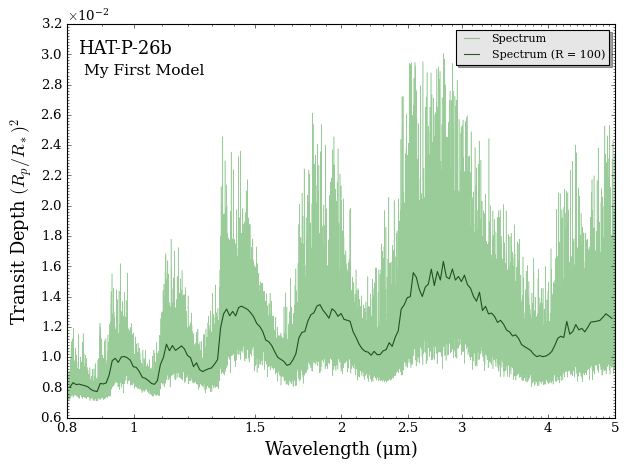

In [9]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our first transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 100, plt_label = 'My First Model')


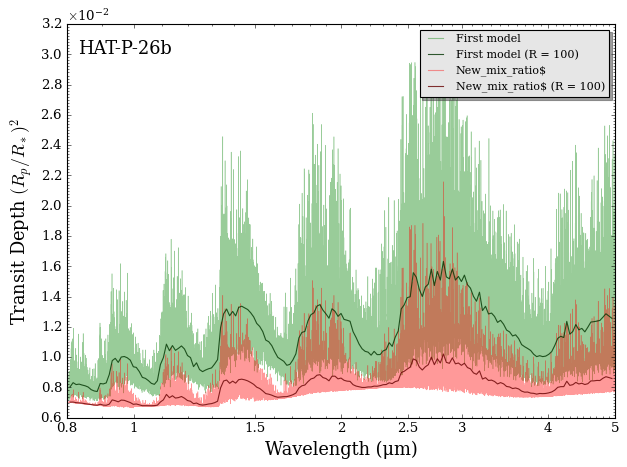

In [10]:
# Define new mixing ratio array
log_X_params_new = np.array([[-5.1]])  # log(H2O)

# Create a new atmosphere without CH4
atmosphere_new = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                    PT_params, log_X_params_new)

# Generate the new transmission spectrum
spectrum_new = compute_spectrum(planet, star, model, atmosphere_new, 
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_new, wl, collection = spectra) 

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100,
                        spectra_labels = ['First model', 'New_mix_ratio$'])


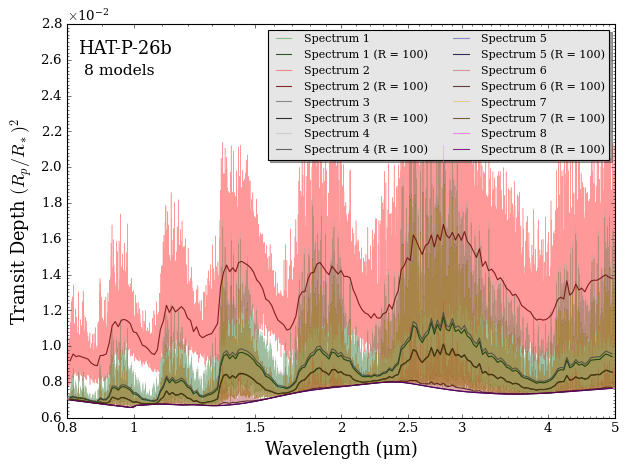

In [11]:
# Generating 8spectras with variable H2O mixing ratios given in an array having random values between -13 and -1
log_X_params_array = np.random.uniform(-13, -1, 8).reshape(8, 1)
spectra_array = []
for i in range(8):
    atmosphere_array = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params_array[i])
    spectrum_array = compute_spectrum(planet, star, model, atmosphere_array, opac, wl, spectrum_type = 'transmission')
    spectra_array = plot_collection(spectrum_array, wl, collection = spectra_array)

# plot the spectras only at R=100 for all 100 models
fig_spec_array = plot_spectra(spectra_array, planet, R_to_bin = 100, plt_label = '8 models')


## Generatin 100,000 forward models

In [40]:
import multiprocessing
from spectres import spectres
## Generating 100000 random values of logH20 in the range -8 to 0 
## which corrresponds to volume mixing ratio of H2O of 1e-8 to 1
log_X_params_100000 = np.random.uniform(-8, 0, 100000).reshape(100000, 1)

## wavelength grid for R=1000
wl_r1000 = wl_grid_constant_R(wl_min, wl_max, 1000)

def my_function(i):
    atmosphere_full = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, samples[i])
    spectrum_full = compute_spectrum(planet, star, model, atmosphere_full, opac, wl, spectrum_type = 'transmission')
    binned_spectra_r1000 = spectres(wl_r1000,wl,spectrum_full,verbose=False)
    return binned_spectra_r1000

if __name__ == '__main__':
    samples = log_X_params_100000
    num_processors = 30
    with multiprocessing.Pool(num_processors) as pool:
        trans_spectras = pool.map(my_function, range(len(samples)))

# saving the generated forward models and the corresponding parameters and wavelenghts 
path_gsoc_data = '/home/gauravs/'
np.save(path_gsoc_data+'poseidon_trans_spectras_R1000',trans_spectras)
np.save(path_gsoc_data+'poseidon_params_logH20_R1000',log_X_params_100000)
np.save(path_gsoc_data+'poseidon_wl_r1000',wl_r1000)

In [42]:
trans_spectras_r1000 = np.load(path_gsoc_data+'poseidon_trans_spectras_R1000.npy')
trans_spectras_r1000.shape

(100000, 2159)